In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ast import literal_eval
import torch.nn as nn
import tqdm

In [2]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install nltk
!python -m nltk.downloader punkt
!pip install pytorch-ignite
!pip install torcheval

     |████████████████████████████████| 12.8 MB 19.5 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
/home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /home/akshay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
import spacy
import string

In [4]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
import random

word_tokenize("I am akshay")

['I', 'am', 'akshay']

In [5]:
%set_env CUDA_VISIBLE_DEVICES=0,1,2,3,4,5,6
%env CUDA_VISIBLE_DEVICES

env: CUDA_VISIBLE_DEVICES=0,1,2,3,4,5,6


'0,1,2,3,4,5,6'

## Preprocessing

In [6]:
STRT = "<START>"
END = "<END>"
UNK = "<UNK>"
PAD = ""

In [7]:
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words
print(stop_words)

{'are', 'seems', 'already', 'own', 'beforehand', 'make', 'such', 'with', 'between', 'even', 'everything', 'mine', 'but', 'you', 'serious', 'too', 'behind', 'call', 'an', 'becoming', 'former', 'themselves', 'during', 'give', 'whenever', 'formerly', 'although', 'your', 'front', 'so', 'be', 'just', 'across', '‘d', 'was', 'been', 'am', 'towards', 'whereupon', 'have', 'ours', 'latterly', 'sometime', 'next', 'ten', 'would', "'re", 'it', 'first', 'do', "'d", 'will', 'why', 'may', 'amongst', 'us', '’s', 'almost', 'four', 'every', 'twelve', 'by', 'before', 'hence', 'another', 'when', 'much', 'whereas', "'s", 'only', 'somehow', 'others', 'moreover', 'some', 'mostly', 'say', '’ve', 'rather', 'herself', 'along', 'among', 'toward', 'me', 'can', 'done', 'wherein', 'herein', 'n‘t', 'least', 'though', 'take', 'here', 'move', 'ever', 'per', 'via', 'whither', 'while', 'since', 'ca', 'our', 'ourselves', 'how', 'my', '‘re', 'cannot', 'because', 'forty', 'without', 'something', 'due', 'bottom', 'hundred', 

In [8]:
punctuations = string.punctuation
print(punctuations)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [9]:
punctuations_to_remove = "\"#$%&'()*+-/<=>[\]^_`{|}~"

In [10]:
import gensim.downloader as api
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [11]:
def mean_wordvector(wv,keys):
    cnt = 0
    mean_wv = None
    for k in keys:
        cv = wv[k]
        if mean_wv is None:
            mean_wv = cv
        else:
            mean_wv = (mean_wv * (cnt-1) + cv)/cnt
        cnt+=1
    
    return mean_wv

In [12]:
def get_extra_token_rep(wv,num_samples):
    random_indices=np.array(random.sample(range(0,len(wv)), num_samples))
    klist = [wv.index_to_key[k] for k in random_indices]
    return mean_wordvector(wv,klist)

In [13]:
def get_combined_frequency(wordvec_obj_list,key):
    overall_freq = 0
    for word_vec_obj in wordvec_obj_list:
        if key in word_vec_obj:
            try:
                overall_freq += word_vec_obj.get_vecattr(key, "count")
            except IndexError:
                print("IndexErrpr",key)
    
    return overall_freq

def form_overall_key_to_index(wordvec_obj_list):
    overall_keys = set()
    for word_vec_obj in wordvec_obj_list:
        overall_keys.update(list(word_vec_obj.key_to_index.keys()))
    
    # Order such that highest frequency keys are in the beginning. This is required for doing adaptivelogsoftmax
    ret = sorted(overall_keys,reverse=True, key=lambda item: get_combined_frequency(wordvec_obj_list,item))
    ret_dict = {ret[i]:i for i in range(len(ret))}
    return ret_dict,ret

In [14]:
def add_UNK_STRT_END_to_W2V(word2vec_obj_list):
    random.seed(10)
    for word_vec_obj in word2vec_obj_list:
        word_vec_obj[UNK] = mean_wordvector(word_vec_obj,word_vec_obj.key_to_index.keys())
        word_vec_obj.set_vecattr(UNK,"count",15000000)
        word_vec_obj[STRT] = get_extra_token_rep(word_vec_obj,10)
        word_vec_obj.set_vecattr(STRT,"count",15000000)
        word_vec_obj[END] = get_extra_token_rep(word_vec_obj,10)
        word_vec_obj.set_vecattr(END,"count",15000000)
        word_vec_obj[PAD] = np.zeros_like(word_vec_obj[END])
        word_vec_obj.set_vecattr(PAD,"count",15000011)

In [15]:
glove_twitter_200_wv = api.load('glove-twitter-200')
gnews_300_wv = api.load('word2vec-google-news-300')

In [16]:
len(glove_twitter_200_wv.key_to_index),len(gnews_300_wv.key_to_index)

(1193514, 3000000)

In [17]:
glove_twitter_200_wv.most_similar("cricket"),gnews_300_wv.most_similar("cricket")

([('england', 0.6504806280136108),
  ('rugby', 0.6489739418029785),
  ('lanka', 0.6265019774436951),
  ('ipl', 0.6233053803443909),
  ('sachin', 0.6209328770637512),
  ('odi', 0.6159676313400269),
  ('football', 0.6020534038543701),
  ('batting', 0.601995587348938),
  ('pakistan', 0.597729504108429),
  ('footy', 0.5967651605606079)],
 [('cricketing', 0.8372225761413574),
  ('cricketers', 0.8165745735168457),
  ('Test_cricket', 0.8094819784164429),
  ('Twenty##_cricket', 0.8068488240242004),
  ('Twenty##', 0.7624265551567078),
  ('Cricket', 0.7541396617889404),
  ('cricketer', 0.7372578382492065),
  ('twenty##', 0.7316356897354126),
  ('T##_cricket', 0.7304614186286926),
  ('West_Indies_cricket', 0.698798656463623)])

In [18]:
# These two W2V combined shall be on of the word representations
word2vec_obj_list = [glove_twitter_200_wv,gnews_300_wv]

In [19]:
# Add UNK,START,END token into dictionary
add_UNK_STRT_END_to_W2V(word2vec_obj_list)

In [20]:
overall_key_to_index,overall_index_to_key = form_overall_key_to_index(word2vec_obj_list)
vocab_size = len(overall_key_to_index)
vocab_size

4112151

In [21]:
def spacy_lemmatizer(sentence,is_remove_stopword=False,punctuations_to_remove="",verbose=False):
    # Creating our token object, which is used to create documents with linguistic annotations.
    doc = nlp(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in doc ]
    if(verbose):
        print(mytokens)

    # Removing stop words
    mytokens = [ word for word in mytokens if (not is_remove_stopword or word not in stop_words) and word not in punctuations_to_remove ]

    # return preprocessed list of tokens
    return mytokens

In [22]:
def nltk_stemmer(sentence,is_remove_stopword=False,punctuations_to_remove="",verbose=False):
    stemmer_obj = SnowballStemmer(language='english')
    mytokens = word_tokenize(sentence)
    # print(mytokens)
    # Removing stop words and punctuations
    mytokens = [ stemmer_obj.stem(word) for word in mytokens if (not is_remove_stopword or word not in stop_words) and word not in punctuations_to_remove ]

    # return preprocessed list of tokens
    return mytokens

#### Different variations during tokenization

##### Lemmatization

In [23]:
# With removing stopwords
spacy_lemmatizer("This is Bangalore. I am living here!",True,verbose=True)

['this', 'be', 'bangalore', '.', 'i', 'be', 'live', 'here', '!']


['bangalore', '.', 'live', '!']

In [24]:
# With removing punctuations
spacy_lemmatizer("This is Bangalore. I am living here!",False,punctuations_to_remove,verbose=True)

['this', 'be', 'bangalore', '.', 'i', 'be', 'live', 'here', '!']


['this', 'be', 'bangalore', '.', 'i', 'be', 'live', 'here', '!']

In [25]:
# With removing stopwords and punctuations
spacy_lemmatizer("This is Bangalore. I am living here!",True,punctuations_to_remove,verbose=True)

['this', 'be', 'bangalore', '.', 'i', 'be', 'live', 'here', '!']


['bangalore', '.', 'live', '!']

In [26]:
# Without removing punctuation and stopwords
spacy_lemmatizer("This is Bangalore. I am living here!",verbose=True)

['this', 'be', 'bangalore', '.', 'i', 'be', 'live', 'here', '!']


['this', 'be', 'bangalore', '.', 'i', 'be', 'live', 'here', '!']

We will not be removing the stopwords and punctuations since it will be beneficial for seq2seq architecture. The other lemmatization variations with stopwords and punctuations are more useful for simpler models.

##### Stemming

In [27]:
nltk_stemmer("This is Bengaluru. I am living here!")

['this', 'is', 'bengaluru', '.', 'i', 'am', 'live', 'here', '!']

Stemming is sufficient especially when corpus is large since it is very fast.

#### Sentence Vectorization
This is applied over the tokens.
This can be done either by certain dedicated algorithms like Bag of words,TF-IDF or by taking the average word representation in sentence using word representations like Word2Vec,Glove etc..\\
We will be using word representation since we will be using seq2seq

In [28]:
# Skips UNKNOWN words while generating sentence representation
def average_word_rep_sentence_vectorizer(sent_tokens,word_vector_obj_list):
    """
    sent_tokens: 1-D list of tokens each of type str
    word_vector_obj_list : list of word2vec gensim objects
    """
    res_list = []
    for word_vector_obj in word_vector_obj_list:
        vector_size = word_vector_obj.vector_size
        wv_res = np.zeros(vector_size)
        # print(wv_res)
        ctr = 1
        for w in sent_tokens:
            if w in word_vector_obj:
                ctr += 1
                wv_res += word_vector_obj[w]
        wv_res = wv_res/ctr
    res_list = np.concatenate(res_list,axis=-1)
    return res_list

def sentence_vectorizer_using_wordembed(sent_tokens,word_vector_obj_list):
    """
    sent_tokens: 1-D list of tokens each of type str
    word_vector_obj_list : list of word2vec gensim objects
    """
    res_list = []
    for each_token in sent_tokens:
        overall_word_rep = []
        for word_vector_obj in word_vector_obj_list:
            if each_token not in word_vector_obj:
                each_token = UNK
            overall_word_rep.append(word_vector_obj[each_token])

        res_list.append(np.concatenate(overall_word_rep,axis=-1))
    
    return np.stack(res_list)

def convert_tokens_to_indices(sent_tokens,overall_key_to_index):
    res_list = []
    for each_token in sent_tokens:
        if each_token not in overall_key_to_index:
                each_token = UNK
        res_list.append(overall_key_to_index[each_token])
    
    return res_list

def add_start_end_tags(sent_tokens):
    sent_tokens.insert(0,STRT)
    sent_tokens.append(END)
    return sent_tokens


### Dataset read

In [29]:
import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/CNN-DailyMail News Dataset/train.csv
./data/CNN-DailyMail News Dataset/validation.csv
./data/CNN-DailyMail News Dataset/test.csv


In [30]:
train_data = pd.read_csv('./data/CNN-DailyMail News Dataset/train.csv')
test_data = pd.read_csv('./data/CNN-DailyMail News Dataset/test.csv')
valid_data = pd.read_csv('./data/CNN-DailyMail News Dataset/validation.csv')

In [31]:
tmp = train_data.sample(5)
tmp["new"] = tmp["article"].apply(lambda x: nltk_stemmer(x,punctuations_to_remove=punctuations_to_remove))
tmp

,id,article,highlights,new
187130,7e581ac83cb4685263677a1189fab319bd1abb8e,By . Steve Nolan . Perfectly balancing a pile ...,Australian cattle dog Jack can balance almost ...,"[by, ., steve, nolan, ., perfect, balanc, a, p..."
116401,223c6b270a0be19552d101332936f63d0e584697,This is the moment a frustrated student turns ...,High school pupil Jeff Bliss filmed ranting at...,"[this, is, the, moment, a, frustrat, student, ..."
193062,85f6c92de756c78b24f84f188c2f705379a53081,"Dallas, Texas (CNN) -- African-American worker...",Investigators say African-American pipe factor...,"[dalla, ,, texa, cnn, --, african-american, wo..."
156498,5653c0912796dfb315e303c68e80b7fdec752c4d,"By . Bianca London . PUBLISHED: . 07:00 EST, 1...","Ollie, 25, is 5ft 10in (178cm) and weighed 9st...","[by, ., bianca, london, ., publish, :, ., 07:0..."
192377,8511b3d611f8fa906f06ee87a904a34a503a474a,"By . Ben Endley . PUBLISHED: . 11:23 EST, 6 Fe...","Jayne Goodwin, 44, died after falling while ou...","[by, ., ben, endley, ., publish, :, ., 11:23, ..."


In [32]:
import torch
from torch.utils.data import Dataset, DataLoader

In [33]:
class TextSummarizationDataset(Dataset):
    def __init__(self, pandas_frame,tokenizer_func,punctuations_to_remove,word_vector_obj_list=[],is_remove_stopwords=False,src_transform=None,target_transform=None,overall_key_to_index=None,src_sent_key="article",target_sent_key="highlights"):
        """
        pandas_frame: pandas frame to read data from
        src_sent_key: key in pandas frame whose value acts as source sentence
        target_sent_key: key in pandas frame whose value acts as target sentence
        tokenizer_func: Function which tokenizes each key
        punctuations_to_remove: A string which contains characters to remove during tokenization
        word_vector_obj_list: List of word2vec objects which is used during vectorization of tokens
        src_transform and target_transform: Vectorizer on source and target sentences respectively. If None,skip W2v vectorization
        overall_key_to_index: If None,
        """
        self.pandas_frame = pandas_frame
        self.src_key = src_sent_key
        self.target_key = target_sent_key
        self.src_transform = src_transform
        self.target_transform = target_transform
        self.tokenizer_func = tokenizer_func
        self.is_remove_stopwords = is_remove_stopwords
        self.punctuations_to_remove = punctuations_to_remove
        self.word_vector_obj_list = word_vector_obj_list
        self.overall_key_to_index = overall_key_to_index

    def __len__(self):
        return len(self.pandas_frame)

    def __getitem__(self, idx):
        source_token,target_token = self.pandas_frame.iloc[idx][self.src_key],self.pandas_frame.iloc[idx][self.target_key]
        # This is needed in case the pandas dataframe was converted to string from list during preprocessing save
        if(source_token[0]=='[' and source_token[-1]==']'):
            source_token = literal_eval(source_token)
            target_token = literal_eval(target_token)
        
        if(self.tokenizer_func is not None):
            # Convert sentence/document into a list of token using either lemmatization or stemming
            source_token = self.tokenizer_func(source_token,self.is_remove_stopwords,self.punctuations_to_remove)
            target_token = self.tokenizer_func(target_token,self.is_remove_stopwords,self.punctuations_to_remove)
            # Add STRT and END tag at start and end of sentence/document respectively
            target_token = add_start_end_tags(target_token)
        # Shift label one step to right
        label_token = target_token[1:]
        # Leave out last timestep in target token
        target_token = target_token[:-1]
        # print("{}--{}--{}".format(idx,len(source_token),len(target_token)))
        source_seq = None
        target_seq = None
        source_vec = None
        target_vec = None
        if self.overall_key_to_index:
            source_seq = convert_tokens_to_indices(source_token,self.overall_key_to_index)
            target_seq = convert_tokens_to_indices(target_token,self.overall_key_to_index)
            label_seq = convert_tokens_to_indices(label_token,self.overall_key_to_index)
        
        # These transform functions are sentence/doc vectorizers
        if self.src_transform:
            source_vec = self.src_transform(source_token,self.word_vector_obj_list)
        if self.target_transform:
            target_vec = self.target_transform(target_token,self.word_vector_obj_list)
        
        return source_vec, target_vec, source_seq, target_seq,label_seq

In [34]:
def fill_in_zero_array(inp,M,N):
    if(M==0):
        return None
    Z = np.zeros((M, N))
    for enu, row in enumerate(inp):
        Z[enu, :len(row)] += row
    return Z


def custom_collate(original_batch):
    
    max_srcvec_seqlen = 0
    max_tarvec_seqlen = 0
    max_srcind_seqlen = 0
    max_tarind_seqlen = 0
    max_labind_seqlen = 0
    for each_batch in original_batch:
        if each_batch[0] is not None:
            max_srcvec_seqlen = max(max_srcvec_seqlen,each_batch[0].shape[0])
        if each_batch[1] is not None:
            max_tarvec_seqlen = max(max_tarvec_seqlen,each_batch[1].shape[0])
        if each_batch[2] is not None:
            max_srcind_seqlen = max(max_srcind_seqlen,len(each_batch[2]))
        if each_batch[3] is not None:
            max_tarind_seqlen = max(max_tarind_seqlen,len(each_batch[3]))
        if each_batch[4] is not None:
            max_labind_seqlen = max(max_labind_seqlen,len(each_batch[4]))
    
    ret_src_vec = []
    ret_tar_vec = []
    ret_src_seq = []
    ret_tar_seq = []
    ret_lab_seq = []
    for each_batch in original_batch:
        src_vec,tar_vec,src_seqind,tar_seqind,lab_seqind = each_batch
        if src_vec is not None:
            ret_src_vec.append(fill_in_zero_array(src_vec,max_srcvec_seqlen,src_vec.shape[1]))
        if tar_vec is not None:
            ret_tar_vec.append(fill_in_zero_array(tar_vec,max_tarvec_seqlen,tar_vec.shape[1]))
        if src_seqind is not None:
            tmp = np.array(src_seqind)
            ret_src_seq.append(np.pad(tmp,(0,max_srcind_seqlen-tmp.shape[0])))
        if tar_seqind is not None:
            tmp = np.array(tar_seqind)
            ret_tar_seq.append(np.pad(tmp,(0,max_tarind_seqlen-tmp.shape[0])))
        if lab_seqind is not None:
            tmp = np.array(lab_seqind)
            ret_lab_seq.append(np.pad(tmp,(0,max_labind_seqlen-tmp.shape[0])))
    
    if len(ret_src_vec)>0:
        ret_src_vec = np.stack(ret_src_vec)
        ret_src_vec = torch.from_numpy(ret_src_vec).float()
    if len(ret_tar_vec)>0:
        ret_tar_vec = np.stack(ret_tar_vec)
        ret_tar_vec = torch.from_numpy(ret_tar_vec).float()
    if len(ret_src_seq)>0:
        ret_src_seq = np.stack(ret_src_seq)
        ret_src_seq = torch.from_numpy(ret_src_seq).long()
    if len(ret_tar_seq)>0:
        ret_tar_seq = np.stack(ret_tar_seq)
        ret_tar_seq = torch.from_numpy(ret_tar_seq).long()
    if len(ret_lab_seq)>0:
        ret_lab_seq = np.stack(ret_lab_seq)
        ret_lab_seq = torch.from_numpy(ret_lab_seq).long()

    return ret_src_vec,ret_tar_vec,ret_src_seq,ret_tar_seq,ret_lab_seq


Running tokenizer or stemmer per batch is costly business so we will use the preprocessed file which we generated using preprocessing functions above

In [35]:
processed_train_data = pd.read_csv('./processed_dataset/spacy_lemmatizer/train_data.csv')
processed_valid_data = pd.read_csv('./processed_dataset/spacy_lemmatizer/validation.csv')
processed_test_data = pd.read_csv('./processed_dataset/spacy_lemmatizer/test.csv')

In [36]:
train_data.iloc[:5]

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [37]:
processed_train_data.iloc[:5]

,Unnamed: 0,id,article,highlights
0,0,0001d1afc246a7964130f43ae940af6bc6c57f01,"['by', '.', 'associated', 'press', '.', 'publi...","['<START>', 'bishop', 'john', 'folda', ',', 'o..."
1,1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,"['cnn', '--', 'ralph', 'mata', 'be', 'an', 'in...","['<START>', 'criminal', 'complaint', ':', 'cop..."
2,2,00027e965c8264c35cc1bc55556db388da82b07f,"['a', 'drunk', 'driver', 'who', 'kill', 'a', '...","['<START>', 'craig', 'eccleston', 'todd', ',',..."
3,3,0002c17436637c4fe1837c935c04de47adb18e9a,"['cnn', '--', 'with', 'a', 'breezy', 'sweep', ...","['<START>', 'nina', 'do', 'santos', 'say', 'eu..."
4,4,0003ad6ef0c37534f80b55b4235108024b407f0b,"['fleetwood', 'be', 'the', 'only', 'team', 'st...","['<START>', 'fleetwood', 'top', 'of', 'league'..."


In [38]:
train_ts_spacy_ds = TextSummarizationDataset(processed_train_data,None,punctuations_to_remove,word2vec_obj_list,src_transform=sentence_vectorizer_using_wordembed,
        target_transform=sentence_vectorizer_using_wordembed,overall_key_to_index=overall_key_to_index)
train_dataloader = torch.utils.data.DataLoader(
        train_ts_spacy_ds, shuffle=False, pin_memory=True, num_workers=4, batch_size=32,collate_fn=custom_collate)

In [39]:
tst = next(iter(train_dataloader))
type(tst[0]),tst[0].size(),tst[0].dtype,tst[1].size(),tst[1].dtype,tst[2].size(),tst[2].dtype,tst[3].size(),tst[3].dtype,tst[4].size(),tst[4].dtype

(torch.Tensor,
 torch.Size([32, 1688, 500]),
 torch.float32,
 torch.Size([32, 136, 500]),
 torch.float32,
 torch.Size([32, 1688]),
 torch.int64,
 torch.Size([32, 136]),
 torch.int64,
 torch.Size([32, 136]),
 torch.int64)

## Model Architecture

In [40]:
def get_index_freq_dist_in_chunks(overall_key_to_index,word2vec_obj_list,chunk_size):
    index_freq_dist = []
    cnt = 0
    cf=0
    for key in overall_key_to_index.keys():
        cf += get_combined_frequency(word2vec_obj_list,key)
        cnt+=1
        if(cnt==chunk_size):
            index_freq_dist.append(cf//cnt)
            cnt = 0
            cf = 0
    index_freq_dist.append(cf)
    return index_freq_dist

In [41]:
index_freq_dist = get_index_freq_dist_in_chunks(overall_key_to_index,word2vec_obj_list,5000)

The following plot is used to check the frequency of chunks of words(since individually plotting is expensive). It is helpful during setting cutoffs in adaptivelogsoftmax

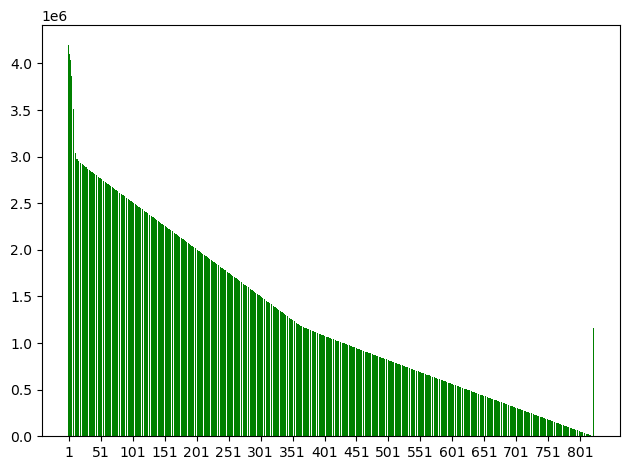

In [42]:
plt.bar(range(len(index_freq_dist)), index_freq_dist, color='g')
plt.xticks(np.arange(1,len(index_freq_dist), 50))
plt.tight_layout()

In [43]:
rd = torch.randn((6))
yt = torch.tensor([1.0,0,1,0,2,2])
rd.requires_grad_()
yt.requires_grad_()
by = rd[yt != 0]
print(rd,by)
sm = torch.sum(by)
sm.backward()
print(rd.grad,yt.grad)

tensor([-1.4708,  1.9016,  2.1126,  0.4210, -0.0634,  0.2123],
       requires_grad=True) tensor([-1.4708,  2.1126, -0.0634,  0.2123], grad_fn=<IndexBackward0>)
tensor([1., 0., 1., 0., 1., 1.]) None


In [63]:
class LSTM_CNN_Arch(nn.Module):
    def __init__(self, num_enc_lstm_layers,embed_size,enc_input_size,enc_hidden_size,vocab_size,num_dec_lstm_layers,dec_hidden_size):
        super(LSTM_CNN_Arch, self).__init__()
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
        self.vocab_size = vocab_size
        self.encoder = Enc_LSTM_CNN_Arch(num_enc_lstm_layers,embed_size,enc_input_size,enc_hidden_size,vocab_size)
        self.decoder = Dec_LSTM_CNN_Arch(num_dec_lstm_layers,embed_size,dec_hidden_size,vocab_size)
        self.attention_layer = nn.MultiheadAttention(embed_dim=dec_hidden_size, num_heads=4,kdim=2*enc_hidden_size, vdim=2*enc_hidden_size, batch_first=True, device=self.device)
        # AdaptiveLogSoftmaxWithLoss decreases the compute time drastically when vocab size is massive by forming clusters and doing kind of hierarchical clustering based softmax
        # The cutoffs are set seeing the frequency distribution graph of the W2V vocab words
        self.adapt_smax_layer = nn.AdaptiveLogSoftmaxWithLoss(2*dec_hidden_size, vocab_size,cutoffs=[5000*10,5000*50,5000*150,5000*350],div_value=2.0,device=self.device)
        # self.classification_layer = nn.Linear(2*enc_hidden_size, vocab_size,device=self.device) This doesn't work since vocab size is massive and this single operation becomes the bottleneck
        
    def forward(self, overall_inp,wordvec_obj_list=None,vectorizer_func=None,index_func=None):
        enc_w2v_embed,dec_w2v_embed,enc_ind_embed,dec_ind_embed,labels_seqind=overall_inp
        cur_bs_size = enc_w2v_embed.size()[0]
        overall_loss = None
        # Key attention mask doesn't work for our architecture bcoz CNNs change the number of timesteps in the encoder
        # key_attention_mask = torch.zeros_like(enc_ind_embed,device=self.device,dtype=torch.bool)
        # print("key_attention_mask:{}".format(key_attention_mask.size()))
        # key_attention_mask = torch.where(enc_ind_embed == 0,True,key_attention_mask)
        enc_out,(enc_h_out,enc_c_out) = self.encoder(enc_w2v_embed,enc_ind_embed)
        if dec_w2v_embed is not None:
            dec_out,(dec_h_out,dec_c_out) = self.decoder(dec_w2v_embed,dec_ind_embed)
            attn_out,_ = self.attention_layer(query=dec_out, key=enc_out, value=enc_out, need_weights=False)
            attn_out = torch.cat((attn_out,dec_out),dim=2)
            print("attn_out :{}".format(attn_out.size()))
            output = []
            for ind in range(attn_out.size()[0]):
                output.append(self.adapt_smax_layer.predict(attn_out[ind]))
            output = torch.stack(output)
        
            # If labels are given return loss as well
            if labels_seqind is not None:
                labels_seqind = labels_seqind.to(device=self.device, non_blocking=True)
                overall_loss = 0
                # Need to run adaptivesoftmax for each batch separately
                for ind in range(attn_out.size()[0]):
                    out,_ = self.adapt_smax_layer(attn_out[ind],labels_seqind[ind])
                    # Removing padding entries from tensor before loss calculation
                    out = out[labels_seqind[ind] != 0]
                    overall_loss += torch.mean(-out)
                overall_loss = overall_loss / attn_out.size()[0]
        else:
            # Run this in inference mode. Here we will decode one word at a time. So always output size per timestep is N
            cur_output,dec_h_out,dec_c_out = None,None,None
            output = []
            if wordvec_obj_list is None:
                wordvec_obj_list = word2vec_obj_list
            if vectorizer_func is None:
                vectorizer_func = sentence_vectorizer_using_wordembed
            if index_func is None:
                index_func = convert_tokens_to_indices
            is_done = torch.zeros((cur_bs_size),device=self.device).long()
            while(torch.sum(is_done)<cur_bs_size and len(output)<2000):
                if(cur_output is None):
                    cur_output = [STRT] * cur_bs_size
                else:
                    cur_output = [overall_index_to_key[ind.item()] for ind in cur_output]
                dec_w2v_embed = torch.unsqueeze(torch.from_numpy(vectorizer_func(cur_output,wordvec_obj_list)),dim=1)
                dec_ind_embed = torch.unsqueeze(torch.tensor(index_func(cur_output,overall_key_to_index)),dim=1)
                # print("dec_w2v_embed:{} dec_ind_embed:{}".format(dec_w2v_embed.size(),dec_ind_embed.size()))

                dec_out,(dec_h_out,dec_c_out) = self.decoder(dec_w2v_embed,dec_ind_embed,dec_h_out,dec_c_out)
                attn_out,_ = self.attention_layer(query=dec_out, key=enc_out, value=enc_out, need_weights=False)
                attn_out = torch.squeeze(torch.cat((attn_out,dec_out),dim=2),dim=1)
                print("attn_out :{}".format(attn_out.size()))
                cur_output = self.adapt_smax_layer.predict(attn_out)
                # If a sample is marked done, further sequence is replaced by PAD
                cur_output = torch.where(is_done == 1,0,cur_output)
                # When in a particular sample, END token is seen mark that sample as done
                is_done = torch.where(cur_output == overall_key_to_index[END],1,is_done)
                output.append(cur_output)
            output = torch.transpose(torch.stack(output),0,1)

        return output,overall_loss       


class Enc_LSTM_CNN_Arch(nn.Module):
    def __init__(self, num_enc_lstm_layers,embed_size,enc_input_size,enc_hidden_size,vocab_size):
        super(Enc_LSTM_CNN_Arch, self).__init__()
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
        self.enc_lstm = nn.LSTM(enc_input_size, enc_hidden_size, num_layers=num_enc_lstm_layers, dropout=0.3, bidirectional=True,batch_first=True, device=self.device)
        # Size of feature obtained from Word2Vec and embedding layer better be same to contribute equally(i.e given task embedding size and general W2V embedding size is same)
        self.enc_embed_layer = nn.Embedding(vocab_size,embed_size,device=self.device)
        # 8 denotes the number of words u need to contextualize
        # in_channels is the two embeddings obtained. One from embedding layer and another from Word2Vec
        # The kernel size will reduce the width to length 1 and hence out_channels will become new features and Height become new timesteps
        self.enc_cnn = nn.Conv2d(in_channels=2, out_channels=enc_input_size, kernel_size=(8,embed_size),device=self.device)
    
    def forward(self, enc_w2v_embed,enc_ind_embed):
        enc_ind_embed = enc_ind_embed.to(device=self.device, non_blocking=True)
        enc_w2v_embed = enc_w2v_embed.to(device=self.device, non_blocking=True)
        tmp = torch.unsqueeze(enc_ind_embed,dim=2).to(device=self.device, non_blocking=True)
        enc_ind_embed = self.enc_embed_layer(enc_ind_embed)
        # This will make the embedding zero at padding points
        enc_ind_embed = torch.where(tmp == 0,torch.zeros((enc_ind_embed.size()[-1]),device=self.device),enc_ind_embed)
        tmp = tmp.cpu()
        del tmp
        torch.cuda.empty_cache()
        conv_inp = torch.stack((enc_w2v_embed,enc_ind_embed),dim=1)
        print("conv_inp :{}".format(conv_inp.size()))
        conv_inp = self.enc_cnn(conv_inp)
        # Out channels are the features and height is the number of timesteps
        conv_inp = torch.squeeze(torch.transpose(conv_inp,1,2),-1)
        print("conv_out :{}".format(conv_inp.size()))
        out,(h_out,c_out) = self.enc_lstm(conv_inp)
        print("enc_out :{}".format(out.size()))
        return out,(h_out,c_out)


class Dec_LSTM_CNN_Arch(nn.Module):
    def __init__(self, num_dec_lstm_layers,embed_size,dec_hidden_size,vocab_size):
        super(Dec_LSTM_CNN_Arch, self).__init__()
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
        self.dec_lstm = nn.LSTM(2*embed_size, dec_hidden_size, num_layers=num_dec_lstm_layers, dropout=0.3, bidirectional=False,batch_first=True, device=self.device)
        self.dec_embed_layer = nn.Embedding(vocab_size,embed_size,device=self.device)
    
    def forward(self, dec_w2v_embed,dec_ind_embed,dec_h_out=None,dec_c_out=None):
        dec_ind_embed = dec_ind_embed.to(device=self.device, non_blocking=True)
        dec_w2v_embed = dec_w2v_embed.to(device=self.device, non_blocking=True)
        dec_ind_embed = self.dec_embed_layer(dec_ind_embed)
        lstm_inp = torch.cat((dec_w2v_embed,dec_ind_embed),dim=2)
        print("dec_in :{}".format(lstm_inp.size()))
        if(dec_h_out is not None or dec_c_out is not None):
            out,(h_out,c_out) = self.dec_lstm(lstm_inp,(dec_h_out,dec_c_out))
        else:
            out,(h_out,c_out) = self.dec_lstm(lstm_inp)
        print("dec_out :{}".format(out.size()))
        return out,(h_out,c_out)



In [45]:
text_sum_model1 = None

In [61]:
torch.cuda.empty_cache()

In [62]:
if(text_sum_model1 is not None):
    text_sum_model1 = text_sum_model1.cpu()
    del text_sum_model1
    

# embed_size needs to be same as combined W2V size
text_sum_model1 = LSTM_CNN_Arch(num_enc_lstm_layers=3,embed_size=500,enc_input_size=250,enc_hidden_size=200,vocab_size=len(overall_index_to_key),num_dec_lstm_layers=4,dec_hidden_size=220)

In [49]:
# if(o1 is not None):
#     o1 = o1.cpu()
#     del o1
o1,o2 = text_sum_model1(tst)
o1.size(),o2

conv_inp :torch.Size([32, 2, 1688, 500]) data:tensor([[-5.7772e-01, -9.2280e-02, -2.7426e-01,  ...,  2.6245e-02,
         -6.2500e-02, -4.1504e-02],
        [ 3.5132e-01,  5.6084e-04, -2.1488e-01,  ..., -2.7635e-02,
          6.1092e-02,  3.8046e-02],
        [ 5.0029e-01,  5.2210e-01, -5.3418e-02,  ...,  1.2158e-01,
          7.1716e-03,  2.2168e-01],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], device='cuda:0',
       grad_fn=<SelectBackward0>)
conv_out :torch.Size([32, 1681, 250])
enc_out :torch.Size([32, 1681, 400])
dec_in :torch.Size([32, 136, 1000])
dec_out :torch.Size([32, 136, 220])
attn_out :torch.Size([32, 136, 440])


(torch.Size([32, 136]),
 tensor(14.1643, device='cuda:0', grad_fn=<DivBackward0>))

In [64]:
bk = tst[-1]
tst[1]=None
tst[-1]=None
tst[-2] = None
i1,i2 = text_sum_model1(tst)
i1.size(),i2

conv_inp :torch.Size([32, 2, 1688, 500])
conv_out :torch.Size([32, 1681, 250])
enc_out :torch.Size([32, 1681, 400])
dec_in :torch.Size([32, 1, 1000])
dec_out :torch.Size([32, 1, 220])
attn_out :torch.Size([32, 440])
torch.int64 torch.int64
dec_in :torch.Size([32, 1, 1000])
dec_out :torch.Size([32, 1, 220])
attn_out :torch.Size([32, 440])
torch.int64 torch.int64
dec_in :torch.Size([32, 1, 1000])
dec_out :torch.Size([32, 1, 220])
attn_out :torch.Size([32, 440])
torch.int64 torch.int64
dec_in :torch.Size([32, 1, 1000])
dec_out :torch.Size([32, 1, 220])
attn_out :torch.Size([32, 440])
torch.int64 torch.int64
dec_in :torch.Size([32, 1, 1000])
dec_out :torch.Size([32, 1, 220])
attn_out :torch.Size([32, 440])
torch.int64 torch.int64
dec_in :torch.Size([32, 1, 1000])
dec_out :torch.Size([32, 1, 220])
attn_out :torch.Size([32, 440])
torch.int64 torch.int64
dec_in :torch.Size([32, 1, 1000])
dec_out :torch.Size([32, 1, 220])
attn_out :torch.Size([32, 440])
torch.int64 torch.int64
dec_in :torch.Si

(torch.Size([32, 2000]), None)

In [ ]:
get_combined_frequency(word2vec_obj_list,"settlements"),overall_key_to_index["settlements"]

(4029113, 18076)

In [67]:
ot = convert_seq_indx_to_word(i1,overall_index_to_key)
ot[30]

['temperament',
 'dissapointing',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'dissapointing',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'dissapointing',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'dissapointing',
 'dissapointing',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'dissapointing',
 'dissapointing',
 'dissapointing',
 'dissapointing',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'dissapointing',
 'nascent',
 'dissapointing',
 'dissapointing',
 'dissapointing',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'dissapointing',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'dissapointing',
 'dissapointing',
 'nascent',
 'dissapointing',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'dissapointing',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'nascent',
 'nascent',


## Train and inference

In [51]:
from ignite.metrics import Rouge
import torcheval
from torcheval.metrics.functional.text import bleu

In [52]:
# To test BLEU score and ROGUE score
test_src_seq = ["This is Akshay. I am from Mysore","Elephants are wonderful animals on earth with excellent memory."]
test_tar_seq = [["My name is Akshay. I am living in Bengaluru"],["Earth has wonderful animals like elephants which have excellent memory."]]
rgsrcseq = [w.split() for w in test_src_seq]
rgtarseq = [[w[0].split()] for w in test_tar_seq]
rgtst = Rouge()
bscore=torcheval.metrics.functional.bleu_score(test_src_seq,test_tar_seq)
print(bscore)
rgtst.update((rgsrcseq, rgtarseq))
rscores = rgtst.compute()
print(rscores["Rouge-L-F"],rscores)


tensor(0.1936)
0.4222222222222222 {'Rouge-1-P': 0.5079365079365079, 'Rouge-1-R': 0.4222222222222222, 'Rouge-1-F': 0.4222222222222222, 'Rouge-2-P': 0.375, 'Rouge-2-R': 0.2986111111111111, 'Rouge-2-F': 0.2986111111111111, 'Rouge-4-P': 0.125, 'Rouge-4-R': 0.08333333333333333, 'Rouge-4-F': 0.08333333333333333, 'Rouge-L-P': 0.5079365079365079, 'Rouge-L-R': 0.4222222222222222, 'Rouge-L-F': 0.4222222222222222}


In [66]:
def convert_seq_indx_to_word(seq_inds,overall_index_to_key):
    ret_seq_arr = []
    for each_seq_ind in seq_inds:
        tmp = []
        for eind in each_seq_ind:
            tmp.append(overall_index_to_key[eind])
        ret_seq_arr.append(tmp)
    
    return ret_seq_arr

def convert_seq_arr_to_seq_str(seq_arr):
    ret_strs = []
    for each_sq in seq_arr:
        ret_strs.append(' '.join(each_sq))
    return ret_strs

def compute_rogue_and_bluescore(overall_index_to_key,rogue_obj,src_seqind,tar_seqind):
    src_seq_arr = convert_seq_indx_to_word(src_seqind,overall_index_to_key)
    tar_seq_arr = convert_seq_indx_to_word(tar_seqind,overall_index_to_key)

    rogue_obj.update((src_seq_arr,[[w] for w in tar_seq_arr]))
    bscore=torcheval.metrics.functional.bleu_score(convert_seq_arr_to_seq_str(src_seq_arr),[[w] for w in convert_seq_arr_to_seq_str(tar_seq_arr)])

    return bscore

In [54]:
def train_model(net, trainloader, testloader, epochs, optimizer, final_model_save_path,overall_index_to_key, wand_project_name=None):
    device_str = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device_str == 'cuda':
        if(torch.cuda.device_count() > 1):
            print("Parallelizing model")
            net = torch.nn.DataParallel(net)

        cudnn.benchmark = True
    rogue_obj = Rouge()
    is_log_wandb = not(wand_project_name is None)
    best_rouge_f1score = 0
    net.train()
    for epoch in range(epochs):  # loop over the dataset multiple times
        rogue_obj.reset()

        running_loss = 0.0
        running_bleu_score = 0.0
        loader = tqdm.tqdm(trainloader, desc='Training')
        for batch_idx, data in enumerate(loader, 0):
            begin_time = time.time()
            loader.set_description(f"Epoch {epoch+1}")
            # get the inputs; data is a list of [inputs, labels]
            labels_seqind = data[-1]

            # zero the parameter gradients
            optimizer.zero_grad()

            # pass entire batch of all sequence to model.
            outputs_seq_ind,loss = net(data)
            
            loss.backward()
            optimizer.step()
            running_bleu_score += compute_rogue_and_bluescore(overall_index_to_key,rogue_obj,outputs_seq_ind,labels_seqind)

            running_loss += loss.item()

            cur_time = time.time()
            step_time = cur_time - begin_time
            loader.set_postfix(train_loss=running_loss/(batch_idx + 1),
                               blue_score=running_bleu_score/(batch_idx + 1), stime=format_time(step_time))

        train_bleu_score = running_bleu_score/(batch_idx + 1)
        train_roug_scores = rogue_obj.compute()

        test_bleu_score, test_roug_scores = evaluate_model(
            net, testloader)
        print("train_bleu_score:{} test_bleu_score:{} train_roug_scores:{} test_roug_scores:{}".format(train_bleu_score,test_bleu_score,train_roug_scores,test_roug_scores))
        if(is_log_wandb):
            wandb.log({"train_bleu_score": train_bleu_score, "test_bleu_score": test_bleu_score,"train_roug_scores":train_roug_scores,"test_roug_scores":test_roug_scores})

        per_epoch_model_save_path = final_model_save_path.replace(
            "_dir.pt", "")
        if not os.path.exists(per_epoch_model_save_path):
            os.makedirs(per_epoch_model_save_path)
        per_epoch_model_save_path += "/epoch_{}_dir.pt".format(epoch)
        if(epoch % 2 == 0):
            torch.save(net, per_epoch_model_save_path)
        if(test_roug_scores["Rouge-L-F"] >= best_rouge_f1score):
            best_rouge_f1score = test_roug_scores["Rouge-L-F"]
            torch.save(net, final_model_save_path)

    print('Finished Training: Best saved model test best_rouge_f1score is:', best_rouge_f1score)
    return best_rouge_f1score, net


In [55]:
def evaluate_model(net, dataloader):
    net.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    bleu_score = 0
    rogue_obj = Rouge()
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        loader = tqdm.tqdm(dataloader, desc='Testing')
        for batch_idx, data in enumerate(loader, 0):
            labels_seqind = data[-1]
            data[-1] = None
            # calculate outputs by running images through the network
            outputs_seq_ind,_ = net()

            bleu_score += compute_rogue_and_bluescore(overall_index_to_key,rogue_obj,outputs_seq_ind,labels_seqind)
            

    return bleu_score/(batch_idx + 1),rogue_obj.compute()
